In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt


In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1lABUY5LjGAXwI_BEm2Uj35xOz5_ToO5y'
output = 'Dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1lABUY5LjGAXwI_BEm2Uj35xOz5_ToO5y
To: /content/Dataset.zip
100%|██████████| 197M/197M [00:01<00:00, 171MB/s]


'Dataset.zip'

In [3]:
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Preprocessed Dataset/val/altered_frames_cropped/r7B491zbxnw_0_pXJ6HOsm_iY_0.avi_frame_690.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/s8CuBT-MDYE_4_sZqIjquRfck_8.avi_frame_150.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/szxR2kMIWtI_0_saQyF1FPiqw_0.avi_frame_270.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/qpBoMZ8mAiQ_2_qpe2zydDOBM_0.avi_frame_210.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wTsoXbhr0N8_4_wnx2fsN9WP0_1.avi_frame_360.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wedLZCKQSrM_2_uvxJpaN72WQ_2.avi_frame_60.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/rBgM58w-gvM_1_pd8-LGKVGWQ_3.avi_frame_540.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/sZDvg03saDA_4_sZDvg03saDA_4.avi_frame_360.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wedLZCKQSrM_2_uvx

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to the input size of the model
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root='Preprocessed Dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='Preprocessed Dataset/val', transform=transform)
test_dataset = datasets.ImageFolder(root='Preprocessed Dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
def check_data_loader_dim(loader):
    # Checking the dataset
    for images, labels in loader:
        print('Image batch dimensions:', images.shape)
        print('Image label dimensions:', labels.shape)
        break

check_data_loader_dim(train_loader)
check_data_loader_dim(val_loader)
check_data_loader_dim(test_loader)

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


In [26]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer (fc) for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.3MB/s]


In [6]:
from tqdm.auto import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cpu'):
    model.to(device)
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = outputs > 0.0
            running_corrects += torch.sum(preds == labels.view(-1, 1).data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation Phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.view(-1, 1).float())
                running_loss += loss.item() * inputs.size(0)
                preds = outputs > 0.0
                running_corrects += torch.sum(preds == labels.view(-1, 1).data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    return model, (train_losses, train_accuracies, val_losses, val_accuracies)


In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

NameError: ignored

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device=device)


Epoch 1/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 1/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 1/25
Train Loss: 0.4306 Acc: 0.8178
Validation Loss: 0.3984 Acc: 0.8274


Epoch 2/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 2/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2/25
Train Loss: 0.3296 Acc: 0.8653
Validation Loss: 0.3583 Acc: 0.8477


Epoch 3/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 3/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/25
Train Loss: 0.3079 Acc: 0.8720
Validation Loss: 0.3540 Acc: 0.8494


Epoch 4/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 4/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/25
Train Loss: 0.2964 Acc: 0.8743
Validation Loss: 0.3769 Acc: 0.8378


Epoch 5/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 5/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/25
Train Loss: 0.2884 Acc: 0.8810
Validation Loss: 0.3418 Acc: 0.8597


Epoch 6/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 6/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/25
Train Loss: 0.2837 Acc: 0.8797
Validation Loss: 0.3460 Acc: 0.8603


Epoch 7/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 7/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/25
Train Loss: 0.2811 Acc: 0.8843
Validation Loss: 0.3421 Acc: 0.8618


Epoch 8/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 8/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/25
Train Loss: 0.2740 Acc: 0.8865
Validation Loss: 0.3571 Acc: 0.8528


Epoch 9/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 9/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/25
Train Loss: 0.2704 Acc: 0.8861
Validation Loss: 0.3443 Acc: 0.8593


Epoch 10/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 10/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/25
Train Loss: 0.2680 Acc: 0.8884
Validation Loss: 0.3494 Acc: 0.8586


Epoch 11/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 11/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 11/25
Train Loss: 0.2688 Acc: 0.8861
Validation Loss: 0.3502 Acc: 0.8605


Epoch 12/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 12/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/25
Train Loss: 0.2676 Acc: 0.8898
Validation Loss: 0.3513 Acc: 0.8601


Epoch 13/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 13/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/25
Train Loss: 0.2685 Acc: 0.8867
Validation Loss: 0.3643 Acc: 0.8519


Epoch 14/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 14/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/25
Train Loss: 0.2641 Acc: 0.8890
Validation Loss: 0.3550 Acc: 0.8568


Epoch 15/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 15/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/25
Train Loss: 0.2671 Acc: 0.8876
Validation Loss: 0.3543 Acc: 0.8591


Epoch 16/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 16/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/25
Train Loss: 0.2615 Acc: 0.8915
Validation Loss: 0.3606 Acc: 0.8547


Epoch 17/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 17/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/25
Train Loss: 0.2582 Acc: 0.8937
Validation Loss: 0.3559 Acc: 0.8555


Epoch 18/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 18/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/25
Train Loss: 0.2609 Acc: 0.8917
Validation Loss: 0.3481 Acc: 0.8628


Epoch 19/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 19/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/25
Train Loss: 0.2625 Acc: 0.8907
Validation Loss: 0.3541 Acc: 0.8626


Epoch 20/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 20/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/25
Train Loss: 0.2609 Acc: 0.8914
Validation Loss: 0.3568 Acc: 0.8586


Epoch 21/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 21/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 21/25
Train Loss: 0.2582 Acc: 0.8925
Validation Loss: 0.3558 Acc: 0.8622


Epoch 22/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 22/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/25
Train Loss: 0.2598 Acc: 0.8897
Validation Loss: 0.3617 Acc: 0.8565


Epoch 23/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 23/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/25
Train Loss: 0.2603 Acc: 0.8917
Validation Loss: 0.3532 Acc: 0.8588


Epoch 24/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 24/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/25
Train Loss: 0.2579 Acc: 0.8923
Validation Loss: 0.3648 Acc: 0.8544


Epoch 25/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 25/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/25
Train Loss: 0.2599 Acc: 0.8909
Validation Loss: 0.3547 Acc: 0.8599


In [10]:
train_accuracy = [accuracy.cpu().item() for accuracy in metrics[1]]
val_accuracy = [accuracy.cpu().item() for accuracy in metrics[3]]

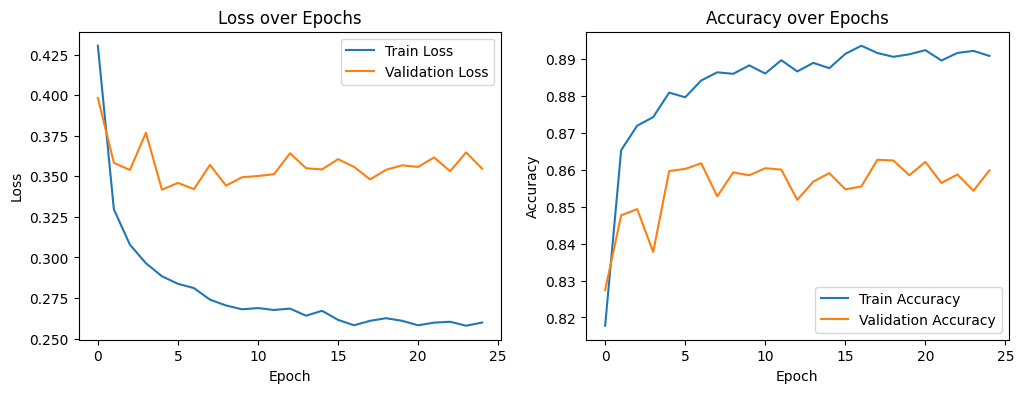

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(metrics[0], label='Train Loss')
plt.plot(metrics[2], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [12]:
torch.save(trained_model, 'Resnet18_model.pth')

In [13]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.3 MB/s eta 0:00:00


In [ ]:
print(trained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
class_names = train_dataset.classes

In [15]:
class_names

['altered_frames_cropped', 'original_frames_cropped']

In [8]:
import torch

# Load the entire model
trained_model = torch.load('/content/Resnet18_model.pth')

# Set to evaluation mode for inference
trained_model.eval()

# Move model to the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=164f2032e3f1d9449b1711964ef729ec41aa4f027d9a9845cbeedf59c542533c
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [9]:
# Ensure the model is in evaluation mode
trained_model.eval()

test_loss = 0
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for data, target in test_loader:
        # Move data to the same device as your model
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = trained_model(data)

        # Compute the loss
        test_loss += criterion(output, target.view(-1, 1).float()).item()

        # Convert output probabilities to predicted class
        preds = output > 0.0

        # Count correct predictions
        correct += torch.sum(preds == target.view(-1, 1).data).item()
        total += target.size(0)

# Calculate average loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.0100, Test Accuracy: 0.8636


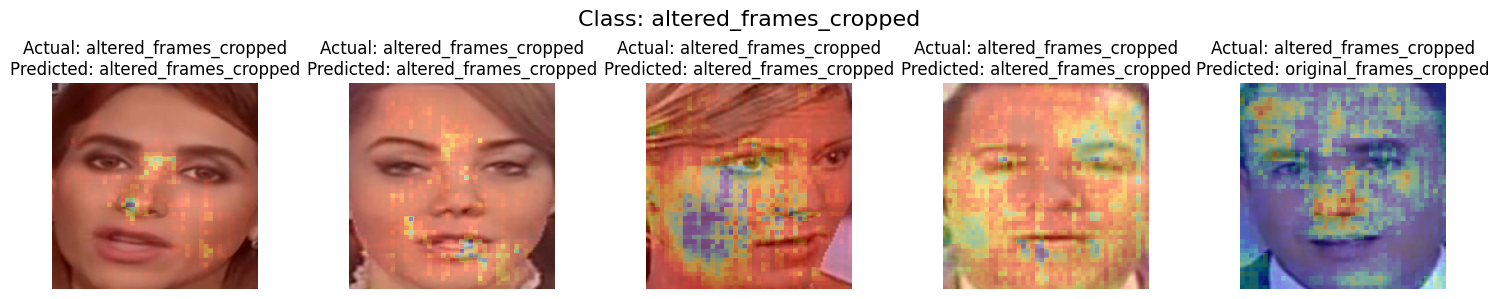

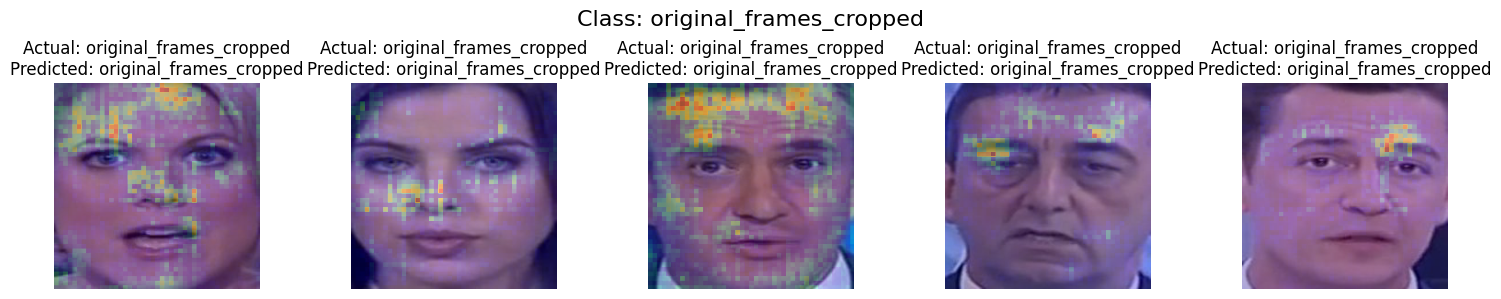

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Assuming that trained_model, test_loader, and device are already defined
# class_names = ['altered_frames_cropped', 'original_frames_cropped']

def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

def overlay_heatmap(heatmap, image, alpha=0.5):
    # Normalize the heatmap and the image for display
    heatmap_normalized = normalize_image(heatmap)
    image_normalized = normalize_image(image)

    # Overlay the heatmap on the image
    plt.imshow(image_normalized)
    plt.imshow(heatmap_normalized, cmap='jet', alpha=alpha)
    plt.axis('off')

def occlusion_sensitivity(model, image, kernel_size=15, stride=5):
    """ Generate occlusion sensitivity heatmap. """
    model.eval()
    image = image.unsqueeze(0).to(device)
    output = model(image)
    pred = torch.sigmoid(output).item()
    occluded = image.clone()
    heatmap = torch.zeros_like(image[0, 0], dtype=torch.float)

    # Generate heatmap
    for i in range(0, image.shape[2], stride):
        for j in range(0, image.shape[3], stride):
            occluded[:, :, i:i+kernel_size, j:j+kernel_size] = 0
            output = model(occluded)
            occluded_pred = torch.sigmoid(output).item()
            heatmap[i:i+kernel_size, j:j+kernel_size] = pred - occluded_pred
            occluded = image.clone()

    # Normalize the original image for visualization
    processed_image = np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0))
    return heatmap.cpu(), processed_image

# Process and plot images
# ... [Previous code] ...

def process_and_plot_images(model, data_loader, class_names, num_images_per_class=5):
    class_images_count = {class_name: 0 for class_name in class_names}
    collected_images = {class_name: [] for class_name in class_names}

    # Collect images for each class
    for images, labels in data_loader:
        for image, label in zip(images, labels):
            actual_class = class_names[label.item()]
            collected_images[actual_class].append((image, label))

    # Randomly select and plot images for each class
    for class_name in class_names:
        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Class: {class_name}", fontsize=16)
        for i in range(num_images_per_class):
            image, label = random.choice(collected_images[class_name])

            # Generate heatmap
            heatmap, processed_image = occlusion_sensitivity(model, image)

            # Predict class
            pred = model(image.unsqueeze(0).to(device))
            predicted_class_index = int(torch.round(torch.sigmoid(pred)).item())
            predicted_class = class_names[predicted_class_index]

            # Plot actual image with heatmap
            plt.subplot(1, num_images_per_class, i+1)
            overlay_heatmap(heatmap, processed_image, alpha=0.3)
            plt.title(f'Actual: {class_name}\nPredicted: {predicted_class}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Call the function to process and plot images
process_and_plot_images(trained_model, test_loader, class_names)

In [14]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import torch

# Make sure your model is in eval mode
trained_model.eval()

# Lists to store actual and predicted labels
actuals = []
predictions = []

# Iterate over the test_loader
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Get predictions from the model
    with torch.no_grad():
        outputs = trained_model(images)

    # Apply sigmoid and round to get the binary class
    predicted_labels = torch.round(torch.sigmoid(outputs)).squeeze()

    # Store the true and predicted labels
    actuals.extend(labels.cpu().numpy())
    predictions.extend(predicted_labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)

# Calculate precision, recall, f1-score, and support
precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')

# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)

print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
[[2355  342]
 [ 394 2303]]

Accuracy: 86.36%
Precision: 0.8706994328922495
Recall: 0.8539117538005191
F1 Score: 0.8622238861849494
